In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.axisbelow': True})
import matplotlib.ticker as mtick

In [2]:
news_citations_df = pd.read_parquet("../data/intermediate/citation_analysis/news_citations.parquet")

# Family

In [30]:
# Define colors and model family mapping
def get_model_provider(model_name):
    if model_name.startswith("gpt-"):
        return "OpenAI"
    elif model_name.startswith("sonar"):
        return "Perplexity"
    elif model_name.startswith("gemini"):
        return "Google"
    else:
        return "Unknown"

provider_colors = {
    'OpenAI': '#2E3440',
    'Google': '#B66A97',
    'Perplexity': '#20808D',
}

provider_marker = {
    "OpenAI": "h",
    "Google": "o",
    "Perplexity": "v"
}

providers = ['OpenAI', "Perplexity", 'Google']

In [4]:
# Calculate Gini coefficients for each model to quantify concentration
def calculate_gini_coefficient(domain_counts):
    """Calculate Gini coefficient from domain citation counts."""
    if len(domain_counts) <= 1:
        return 0

    # Sort in ascending order
    sorted_counts = sorted(domain_counts.values)
    n = len(sorted_counts)

    # Calculate Gini coefficient
    # Gini = (2 * sum(i * x_i)) / (n * sum(x_i)) - (n + 1) / n
    cumsum = 0
    for i, count in enumerate(sorted_counts, 1):
        cumsum += i * count

    total = sum(sorted_counts)
    gini = (2 * cumsum) / (n * total) - (n + 1) / n

    return gini

In [20]:
# Calculate Gini coefficients for model families
family_gini_data = []

for provider in providers:
    provider_citations = news_citations_df[
        news_citations_df['model_name_raw'].apply(get_model_provider) == provider
    ]

    if len(provider_citations) > 0:
        domain_counts = provider_citations['domain'].value_counts()
        gini = calculate_gini_coefficient(domain_counts)

        # Get additional statistics
        unique_models = provider_citations['model_name_raw'].nunique()

        family_gini_data.append({
            'provider': provider,
            'gini_coefficient': gini,
            'num_citations': len(provider_citations),
            'num_domains': len(domain_counts),
            'num_models': unique_models,
            'top_domain': domain_counts.index[0] if len(domain_counts) > 0 else 'N/A',
            'top_domain_pct': domain_counts.iloc[0] / len(provider_citations) * 100 if len(domain_counts) > 0 else 0,
            'avg_citations_per_domain': len(provider_citations) / len(domain_counts) if len(domain_counts) > 0 else 0
        })

# Create DataFrame and sort by Gini coefficient
family_gini_df = pd.DataFrame(family_gini_data)
family_gini_df = family_gini_df.sort_values('gini_coefficient', ascending=False)

print("\\n" + "="*90)
print("NEWS CITATION CONCENTRATION ANALYSIS BY MODEL FAMILY")
print("="*90)
print(f"{'Provider':<12} {'Gini':<6} {'Citations':<10} {'Domains':<8} {'Models':<7} {'Top Domain %':<12} {'Avg/Domain':<10}")
print("-"*90)

for _, row in family_gini_df.iterrows():
    print(f"{row['provider']:<12} {row['gini_coefficient']:.3f}  {row['num_citations']:<10} {row['num_domains']:<8} {row['num_models']:<7} {row['top_domain_pct']:.1f}%        {row['avg_citations_per_domain']:.1f}")

print("\\n" + "="*90)
print("TOP CITED DOMAINS BY MODEL FAMILY:")
print("="*90)

for _, row in family_gini_df.iterrows():
    provider_citations = news_citations_df[
        news_citations_df['model_name_raw'].apply(get_model_provider) == row['provider']
    ]
    top_domains = provider_citations['domain'].value_counts().head(5)

    print(f"\\n{row['provider']} (Top 5 domains):")
    for i, (domain, count) in enumerate(top_domains.items(), 1):
        pct = count / len(provider_citations) * 100
        print(f"  {i}. {domain}: {count:,} citations ({pct:.1f}%)")

print("\\n" + "="*90)
print("INTERPRETATION:")
print("- Gini coefficient: 0 = perfect equality, ~1 = maximum concentration")
print("- Higher Gini = more concentrated (few domains dominate)")
print("- Lower Gini = more distributed (citations spread across many domains)")
print("- Avg/Domain = average citations per unique domain")
print("="*90)

family_gini_df

\n==========================================================================================
NEWS CITATION CONCENTRATION ANALYSIS BY MODEL FAMILY
Provider     Gini   Citations  Domains  Models  Top Domain % Avg/Domain
------------------------------------------------------------------------------------------
OpenAI       0.827  7643       707      4       22.8%        10.8
Perplexity   0.769  19826      1430     5       3.2%        13.9
Google       0.690  5396       881      3       4.3%        6.1
\n==========================================================================================
TOP CITED DOMAINS BY MODEL FAMILY:
\nOpenAI (Top 5 domains):
  1. reuters.com: 1,745 citations (22.8%)
  2. apnews.com: 936 citations (12.2%)
  3. ft.com: 532 citations (7.0%)
  4. axios.com: 511 citations (6.7%)
  5. time.com: 299 citations (3.9%)
\nPerplexity (Top 5 domains):
  1. bbc.com: 639 citations (3.2%)
  2. yahoo.com: 536 citations (2.7%)
  3. 163.com: 389 citations (2.0%)
  4. sohu.com: 38

,provider,gini_coefficient,num_citations,num_domains,num_models,top_domain,top_domain_pct,avg_citations_per_domain
0,OpenAI,0.826638,7643,707,4,reuters.com,22.831349,10.810467
1,Perplexity,0.769108,19826,1430,5,bbc.com,3.223040,13.864336
2,Google,0.690252,5396,881,3,indiatimes.com,4.318013,6.124858


In [45]:
provider_geini = dict(family_gini_df[['provider', 'gini_coefficient']].values)

In [21]:
# Function to calculate Lorenz curve data for model families
def calculate_family_lorenz_curve(citations_df, provider_name):
    """Calculate Lorenz curve for news citation concentration by domain for a model family."""
    # Filter citations for this provider
    provider_citations = citations_df[
        citations_df['model_name_raw'].apply(get_model_provider) == provider_name
    ]

    if len(provider_citations) == 0:
        return [], []

    # Count citations per domain
    domain_counts = provider_citations['domain'].value_counts().sort_values(ascending=False)

    # Calculate cumulative percentages
    total_citations = len(provider_citations)
    total_domains = len(domain_counts)

    # Cumulative citations (sorted from most cited to least cited domains)
    cumulative_citations = domain_counts.cumsum()

    # Convert to percentages
    domain_percentages = [(i + 1) / total_domains * 100 for i in range(len(domain_counts))]
    citation_percentages = [cum_cites / total_citations * 100 for cum_cites in cumulative_citations]

    # Add (0,0) point for complete curve
    domain_percentages = [0] + domain_percentages
    citation_percentages = [0] + citation_percentages

    return domain_percentages, citation_percentages

In [23]:
providers

['OpenAI', 'Perplexity', 'Google']

OpenAI
Perplexity
Google


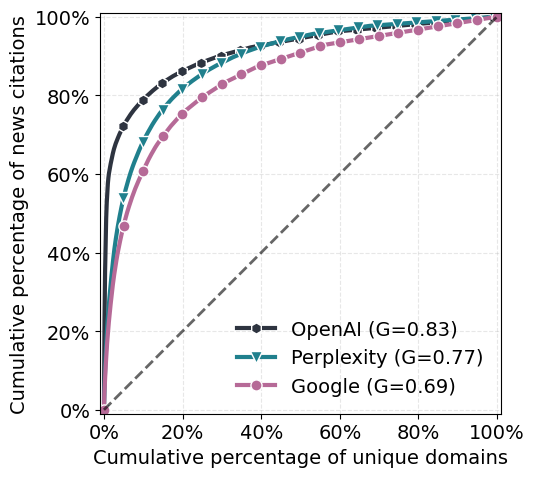

In [49]:
# Create Lorenz curves for model families
fig, ax = plt.subplots(figsize=(6, 5))

# Calculate and plot Lorenz curves for each provider
family_data = []
for provider in providers:
    print(provider)
    x_vals, y_vals = calculate_family_lorenz_curve(news_citations_df, provider)

    color = provider_colors[provider]
    ax.plot(
        x_vals, y_vals,
        color=color,
        alpha=1,
        linewidth=3,
        label=f"{provider} (G={provider_geini[provider]:.2f})",
        marker=provider_marker[provider],
        markersize=8,
        markevery=max(1, len(x_vals)//20),
        markeredgecolor='white',
    )

# Add perfect equality line (45-degree line)
ax.plot([0, 100], [0, 100], 'k--', alpha=0.6, linewidth=2)
ax.set_aspect('equal')
# Customize the plot
ax.set_xlabel('Cumulative percentage of unique domains')
ax.set_ylabel('Cumulative percentage of news citations')

# Set axis limits and formatting
ax.set_xlim(-1, 101)
ax.set_ylim(-1, 101)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Format axes as percentages
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Improve appearance
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

# Add legend
ax.legend(loc='lower right', frameon=False)

plt.tight_layout()

plt.savefig(
    '../data/output/cleaned_arena_data/news_citation_lorenz_curves_families.pdf'
)

# Model

In [8]:
# Function to calculate Lorenz curve data
def calculate_lorenz_curve(citations_df, model_name):
    """Calculate Lorenz curve for news citation concentration by domain."""
    # Filter citations for this model
    model_citations = citations_df[citations_df['model_name_raw'] == model_name]

    if len(model_citations) == 0:
        return [], []

    # Count citations per domain
    domain_counts = model_citations['domain'].value_counts().sort_values(ascending=False)

    # Calculate cumulative percentages
    total_citations = len(model_citations)
    total_domains = len(domain_counts)

    # Cumulative citations (sorted from most cited to least cited domains)
    cumulative_citations = domain_counts.cumsum()

    # Convert to percentages
    domain_percentages = [(i + 1) / total_domains * 100 for i in range(len(domain_counts))]
    citation_percentages = [cum_cites / total_citations * 100 for cum_cites in cumulative_citations]

    # Add (0,0) point for complete curve
    domain_percentages = [0] + domain_percentages
    citation_percentages = [0] + citation_percentages

    return domain_percentages, citation_percentages

# Get unique models
models = news_citations_df['model_name_raw'].unique()
print(f"Found {len(models)} models in news citations data")

# Test with one model first
test_model = models[0]
x_test, y_test = calculate_lorenz_curve(news_citations_df, test_model)
print(f"\\nTest model {test_model}:")
print(f"Domains: {len(x_test)-1}, Citations: {len(news_citations_df[news_citations_df['model_name_raw'] == test_model])}")
print(f"First few points: {list(zip(x_test[:5], y_test[:5]))}")

Found 12 models in news citations data
\nTest model sonar:
Domains: 631, Citations: 2794
First few points: [(0, 0), (0.15847860538827258, 2.6485325697924123), (0.31695721077654515, 5.082319255547603), (0.4754358161648178, 7.40873299928418), (0.6339144215530903, 9.484609878310666)]


Found 12 models in news citations data
\nTest model sonar:
Domains: 631, Citations: 2794
First few points: [(0, 0), (0.15847860538827258, 2.6485325697924123), (0.31695721077654515, 5.082319255547603), (0.4754358161648178, 7.40873299928418), (0.6339144215530903, 9.484609878310666)]


In [14]:
# Calculate Gini coefficients for all models
gini_data = []
for model in models:
    model_citations = news_citations_df[news_citations_df['model_name_raw'] == model]
    if len(model_citations) > 0:
        domain_counts = model_citations['domain'].value_counts()
        gini = calculate_gini_coefficient(domain_counts)

        gini_data.append({
            'model': model,
            'provider': get_model_provider(model),
            'gini_coefficient': gini,
            'num_citations': len(model_citations),
            'num_domains': len(domain_counts),
            'top_domain_pct': domain_counts.iloc[0] / len(model_citations) * 100 if len(domain_counts) > 0 else 0
        })

# Create DataFrame and sort by Gini coefficient
gini_df = pd.DataFrame(gini_data)
gini_df = gini_df.sort_values('gini_coefficient', ascending=False)

print("News Citation Concentration Analysis (Gini Coefficients):")
print("=" * 80)
print(f"{'Model':<35} {'Provider':<12} {'Gini':<6} {'Citations':<10} {'Domains':<8} {'Top Domain %':<12}")
print("-" * 80)

for _, row in gini_df.iterrows():
    print(f"{row['model']:<35} {row['provider']:<12} {row['gini_coefficient']:.3f}  {row['num_citations']:<10} {row['num_domains']:<8} {row['top_domain_pct']:.1f}%")

print("\\nInterpretation:")
print("- Gini coefficient ranges from 0 (perfect equality) to ~1 (maximum inequality)")
print("- Higher Gini = more concentrated citations (few domains get most citations)")
print("- Lower Gini = more distributed citations (citations spread across many domains)")

gini_df

News Citation Concentration Analysis (Gini Coefficients):
Model                               Provider     Gini   Citations  Domains  Top Domain %
--------------------------------------------------------------------------------
gpt-4o-search-preview-high-loc      OpenAI       0.774  2288       366      23.0%
gpt-4o-search-preview               OpenAI       0.770  1985       321      23.5%
gpt-4o-search-preview-high          OpenAI       0.752  1996       358      23.3%
gpt-4o-mini-search-preview          OpenAI       0.713  1374       289      20.9%
sonar-reasoning-pro-high            Perplexity   0.704  5662       809      4.4%
sonar-pro-high                      Perplexity   0.666  5167       867      3.1%
sonar-reasoning                     Perplexity   0.634  3601       742      2.8%
gemini-2.5-pro-exp-03-25-grounding  Google       0.612  2489       606      4.3%
sonar                               Perplexity   0.611  2794       631      2.6%
sonar-pro                           Per

,model,provider,gini_coefficient,num_citations,num_domains,top_domain_pct
7,gpt-4o-search-preview-high-loc,OpenAI,0.773874,2288,366,22.989510
4,gpt-4o-search-preview,OpenAI,0.769789,1985,321,23.526448
5,gpt-4o-search-preview-high,OpenAI,0.751861,1996,358,23.296593
3,gpt-4o-mini-search-preview,OpenAI,0.712768,1374,289,20.887918
10,sonar-reasoning-pro-high,Perplexity,0.704210,5662,809,4.380078
6,sonar-pro-high,Perplexity,0.666410,5167,867,3.135282
1,sonar-reasoning,Perplexity,0.633543,3601,742,2.832547
8,gemini-2.5-pro-exp-03-25-grounding,Google,0.611885,2489,606,4.339092
0,sonar,Perplexity,0.611491,2794,631,2.648533
2,sonar-pro,Perplexity,0.597352,2602,625,2.267487


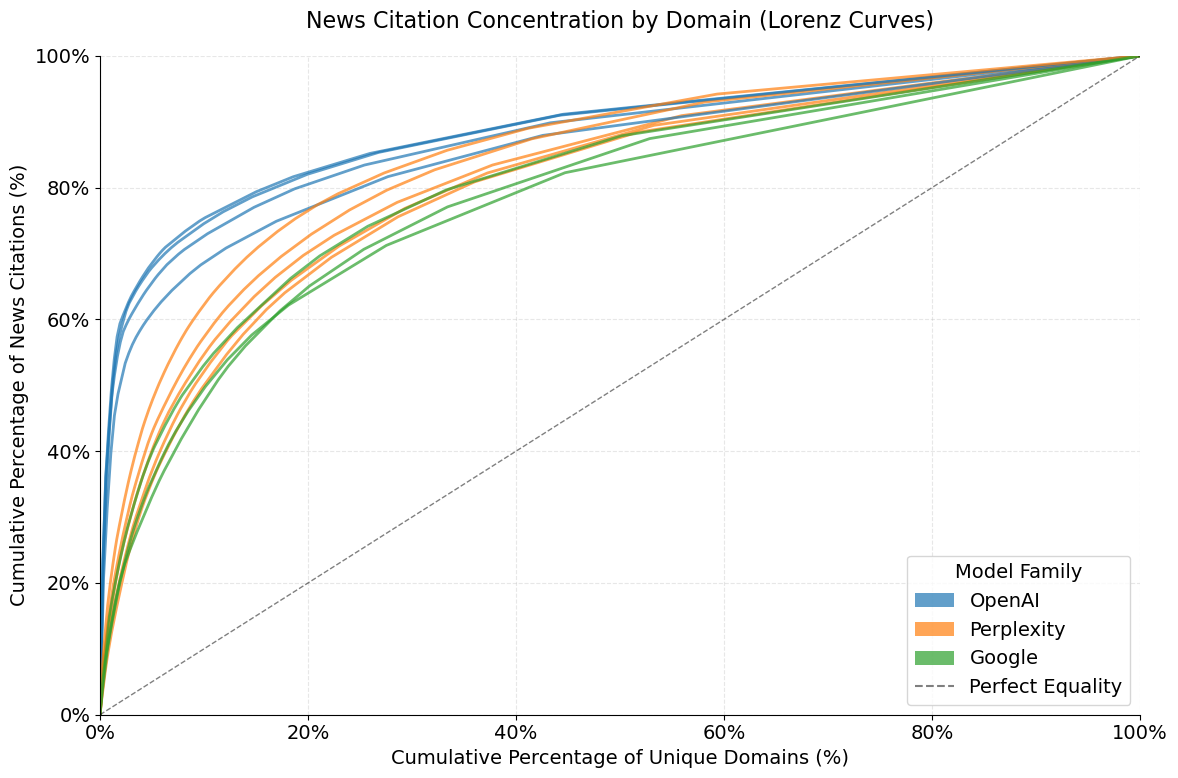

\nLorenz curves figure saved as PNG and PDF
\nSummary of news citation concentration:
sonar-reasoning-pro-high: 5,662 citations across 809 domains
sonar-pro-high: 5,167 citations across 867 domains
sonar-reasoning: 3,601 citations across 742 domains
sonar: 2,794 citations across 631 domains
sonar-pro: 2,602 citations across 625 domains
gemini-2.5-pro-exp-03-25-grounding: 2,489 citations across 606 domains
gpt-4o-search-preview-high-loc: 2,288 citations across 366 domains
gpt-4o-search-preview-high: 1,996 citations across 358 domains
gpt-4o-search-preview: 1,985 citations across 321 domains
gemini-2.5-flash-preview-04-17-grounding: 1,583 citations across 422 domains
gpt-4o-mini-search-preview: 1,374 citations across 289 domains
gemini-2.0-flash-grounding: 1,324 citations across 425 domains


<Figure size 640x480 with 0 Axes>

In [15]:
# Create Lorenz curves for all models
fig, ax = plt.subplots(figsize=(12, 8))


# Calculate and plot Lorenz curves for each model
models_data = []
for model in models:
    x_vals, y_vals = calculate_lorenz_curve(news_citations_df, model)
    if len(x_vals) > 0:  # Only plot if model has data
        provider = get_model_provider(model)
        color = provider_colors[provider]

        # Plot the curve
        ax.plot(x_vals, y_vals, color=color, alpha=0.7, linewidth=2, label=f"{model}")

        # Store data for analysis
        models_data.append({
            'model': model,
            'provider': provider,
            'x_vals': x_vals,
            'y_vals': y_vals,
            'num_domains': len(x_vals) - 1,
            'num_citations': len(news_citations_df[news_citations_df['model_name_raw'] == model])
        })

# Add perfect equality line (45-degree line)
ax.plot([0, 100], [0, 100], 'k--', alpha=0.5, linewidth=1, label='Perfect Equality')

# Customize the plot
ax.set_xlabel('Cumulative Percentage of Unique Domains (%)', fontsize=14)
ax.set_ylabel('Cumulative Percentage of News Citations (%)', fontsize=14)
ax.set_title('News Citation Concentration by Domain (Lorenz Curves)', fontsize=16, pad=20)

# Set axis limits and formatting
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Format axes as percentages
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Improve appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a more manageable legend (group by provider)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=provider, alpha=0.7)
                  for provider, color in provider_colors.items()
                  if provider in [data['provider'] for data in models_data]]
legend_elements.append(plt.Line2D([0], [0], color='k', linestyle='--', alpha=0.5, label='Perfect Equality'))

ax.legend(handles=legend_elements, loc='lower right', title='Model Family')

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('../data/output/cleaned_arena_data/news_citation_lorenz_curves.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('../data/output/cleaned_arena_data/news_citation_lorenz_curves.pdf',
            bbox_inches='tight', facecolor='white')

print("\\nLorenz curves figure saved as PNG and PDF")

# Print summary statistics
print("\\nSummary of news citation concentration:")
for data in sorted(models_data, key=lambda x: x['num_citations'], reverse=True):
    print(f"{data['model']}: {data['num_citations']:,} citations across {data['num_domains']:,} domains")

Found 12 models in news citations data
\nTest model sonar:
Domains: 631, Citations: 2794
First few points: [(0, 0), (0.15847860538827258, 2.6485325697924123), (0.31695721077654515, 5.082319255547603), (0.4754358161648178, 7.40873299928418), (0.6339144215530903, 9.484609878310666)]
